In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, \
    precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from funcsigs import signature
import pandas as pd
import numpy as np
from scipy import stats
import pickle

from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None  # default='warn'

def show_nan_count_per_column(df):
    null_columns = df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum()


def get_value_count(y_):
    y_ = pd.Series(y_)
    true_count = 1  # to avoid divide by 0 - approx
    false_count = 0

    count = y_.value_counts()
    if True in count:
        true_count = count[True]
    if False in count:
        false_count = count[False]
    return true_count, false_count


def show_model_accuracy(algo_name, model, pX_test, py_test, pX_columns, do_roc_curve=False,
                        do_precision_recall_curve=False, do_features_importance=False,
                        do_precision_recall_vs_treshold=False, threshold=0.5, nb_features_imp=20):
    from matplotlib import pyplot as plt
    
    predicted_proba = model.predict(pX_test)    
    predicted = (y_pred > threshold)
    # keep probabilities for the positive outcome only
    probs = predicted_proba
    confusion = confusion_matrix(py_test, predicted)

    # Infos
    print('----------------------------------------------------------')
    print('Results for algorithm : ' + algo_name)
    print('----------------------------------------------------------\n')
    print('Confusion Matrix :\n', confusion)
    print('[[TN, FP]')
    print('[FN, TP]]')
    print('Accuracy: {:.2f}'.format(accuracy_score(py_test, predicted)))
    # print('Precision: {:.2f}'.format(precision_score(py_test, predicted)))
    # print('Recall: {:.2f}'.format(recall_score(py_test, predicted)))
    # print('F1: {:.2f}'.format(f1_score(py_test, predicted)))
    # print('AUC: {:.2f}'.format(roc_auc))
    # print('----------------------------------------------------------\n')
    print('\n\nOther Metrics :\n')
    print(classification_report(py_test, predicted, target_names=['False', 'True']))
    print('----------------------------------------------------------\n')

    # Plot ROC curve
    if do_roc_curve:
        # predicted = model.predict(pX_test)
        # fpr, tpr, thresholds = roc_curve(py_test, predicted)
        fpr, tpr, thresholds = roc_curve(py_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic (ROC Curve)')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate / Sensitivity')
        plt.xlabel('False Positive Rate / 1 - Specificity')
        plt.legend(loc="lower right")
        plt.show()

    # Plot Precision / Recall curve
    if do_precision_recall_curve:
        # predict class values
        yhat = predicted
        # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(py_test, probs)
        # calculate F1 score
        f1 = f1_score(py_test, yhat)
        # calculate precision-recall AUC
        auc_value = auc(recall, precision)
        # calculate average precision score
        ap = average_precision_score(py_test, probs)
        print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_value, ap))
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], label='Treshold 0.5', linestyle='--')
        label = 'Treshold ' + str(threshold)
        plt.plot([0, 1], [threshold, threshold], label=label, linestyle='--')
        # plot the roc curve for the model
        # plt.plot(recall, precision, marker='.')
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        # show the plot
        plt.show()

    if do_precision_recall_vs_treshold:
        precisions, recalls, thresholds = precision_recall_curve(py_test, probs)
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        plt.xlabel("Threshold")
        plt.legend(loc="upper left")
        plt.ylim([0, 1])
        plt.show()

    # View a list of the features and their importance scores
    if do_features_importance:
        feat_importances = pd.Series(model.feature_importances_, index=pX_columns)
        if nb_features_imp > 20:
            plt.figure(figsize=(20, 20))
        feat_importances.nlargest(nb_features_imp).plot(kind='barh')
        plt.show()


def get_useless_features(model, index, threshold=0.002):
    s = pd.Series(model.feature_importances_, index=index)
    return s[s <= threshold].index.values


# Serialization
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [1]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = ColumnTransformer([('one_hot_encoder', OneHotEncoder(),[1])], remainder = 'passthrough')
X = onehotencoder.fit_transform(X)
X = X[:, 1:]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [2]:
# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
# Adding dropout to avoir overfitting - start with 0.1
classifier.add(Dropout(p = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(p = 0.1))

# Adding the output layer - sigmoid to obtain a probability
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Using TensorFlow backend.


Train on 8000 samples
Epoch 1/100
8000/8000 [==============================] - 2s 195us/sample - loss: 0.4986 - accuracy: 0.7958
Epoch 2/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.4276 - accuracy: 0.7960
Epoch 3/100
8000/8000 [==============================] - 1s 113us/sample - loss: 0.4215 - accuracy: 0.8067
Epoch 4/100
8000/8000 [==============================] - 1s 114us/sample - loss: 0.4158 - accuracy: 0.8282
Epoch 5/100
8000/8000 [==============================] - 1s 114us/sample - loss: 0.4108 - accuracy: 0.8320
Epoch 6/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.4076 - accuracy: 0.8336 - loss: 0.4085 - ac
Epoch 7/100
8000/8000 [==============================] - 1s 118us/sample - loss: 0.4052 - accuracy: 0.8354
Epoch 8/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.4031 - accuracy: 0.8344
Epoch 9/100
8000/8000 [==============================] - 1s 117us/sample - loss: 0.4024 - accuracy: 0.

8000/8000 [==============================] - 1s 118us/sample - loss: 0.3438 - accuracy: 0.8606
Epoch 77/100
8000/8000 [==============================] - 1s 119us/sample - loss: 0.3424 - accuracy: 0.8630
Epoch 78/100
8000/8000 [==============================] - 1s 133us/sample - loss: 0.3435 - accuracy: 0.8590
Epoch 79/100
8000/8000 [==============================] - 1s 114us/sample - loss: 0.3429 - accuracy: 0.8611
Epoch 80/100
8000/8000 [==============================] - 1s 115us/sample - loss: 0.3422 - accuracy: 0.8614 - loss: 0.3436 - 
Epoch 81/100
8000/8000 [==============================] - 1s 114us/sample - loss: 0.3434 - accuracy: 0.8610
Epoch 82/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.3427 - accuracy: 0.8594
Epoch 83/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.3432 - accuracy: 0.8581 - l
Epoch 84/100
8000/8000 [==============================] - 1s 116us/sample - loss: 0.3430 - accuracy: 0.8581
Epoch 85/100
8000/8

In [3]:
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

----------------------------------------------------------
Results for algorithm : test_csa
----------------------------------------------------------

Confusion Matrix :
 [[1514   81]
 [ 198  207]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.86


Other Metrics :

              precision    recall  f1-score   support

       False       0.88      0.95      0.92      1595
        True       0.72      0.51      0.60       405

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

----------------------------------------------------------



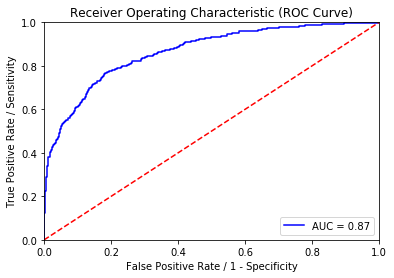

f1=0.597 auc=0.701 ap=0.702


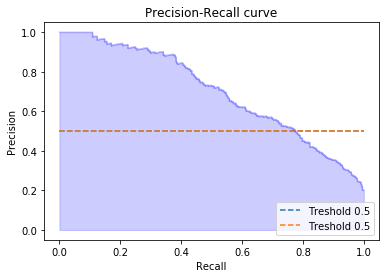

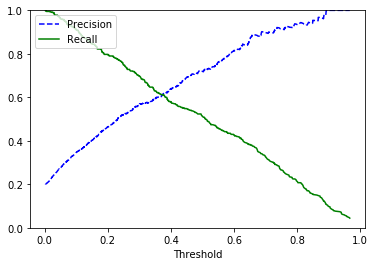

In [15]:
show_model_accuracy('test_csa', classifier, X_test, y_test, None, do_roc_curve=True,
                        do_precision_recall_curve=True, do_features_importance=False,
                        do_precision_recall_vs_treshold=True, threshold=0.5)

In [18]:
# Evaluating the ANN
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

# Improving the ANN
# Dropout Regularization to reduce overfitting if needed

# Tuning the ANN
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Train on 7200 samples
Epoch 1/100
7200/7200 [==============================] - 3s 448us/sample - loss: 0.5551 - accuracy: 0.7968
Epoch 2/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4338 - accuracy: 0.7971
Epoch 3/100
7200/7200 [==============================] - 1s 103us/sample - loss: 0.4281 - accuracy: 0.7971
Epoch 4/100
7200/7200 [==============================] - 1s 100us/sample - loss: 0.4247 - accuracy: 0.7971
Epoch 5/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4218 - accuracy: 0.7971
Epoch 6/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.4195 - accuracy: 0.7999
Epoch 7/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4178 - accuracy: 0.8206
Epoch 8/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4168 - accuracy: 0.8231
Epoch 9/100
7200/7200 [==============================] - 1s 99us/sample - loss: 0.4154 - accuracy: 0.8260
Epoch 10/100
720

7200/7200 [==============================] - 1s 106us/sample - loss: 0.4007 - accuracy: 0.8331
Epoch 77/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4004 - accuracy: 0.8340
Epoch 78/100
7200/7200 [==============================] - 0s 65us/sample - loss: 0.4009 - accuracy: 0.8339
Epoch 79/100
7200/7200 [==============================] - 1s 92us/sample - loss: 0.4008 - accuracy: 0.8339
Epoch 80/100
7200/7200 [==============================] - 1s 94us/sample - loss: 0.4002 - accuracy: 0.8349
Epoch 81/100
7200/7200 [==============================] - 1s 90us/sample - loss: 0.4008 - accuracy: 0.8339
Epoch 82/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4006 - accuracy: 0.8353
Epoch 83/100
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4005 - accuracy: 0.8332
Epoch 84/100
7200/7200 [==============================] - 1s 110us/sample - loss: 0.4005 - accuracy: 0.8346
Epoch 85/100
7200/7200 [=====================

7200/7200 [==============================] - 1s 105us/sample - loss: 0.4015 - accuracy: 0.8340
Epoch 52/100
7200/7200 [==============================] - 1s 107us/sample - loss: 0.4012 - accuracy: 0.8363
Epoch 53/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4013 - accuracy: 0.8353
Epoch 54/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4017 - accuracy: 0.8354
Epoch 55/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.4010 - accuracy: 0.8363
Epoch 56/100
7200/7200 [==============================] - 1s 115us/sample - loss: 0.4011 - accuracy: 0.8351
Epoch 57/100
7200/7200 [==============================] - 1s 125us/sample - loss: 0.4010 - accuracy: 0.8349
Epoch 58/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4006 - accuracy: 0.8351
Epoch 59/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4008 - accuracy: 0.8351
Epoch 60/100
7200/7200 [=================

7200/7200 [==============================] - 1s 110us/sample - loss: 0.3802 - accuracy: 0.8435
Epoch 27/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3794 - accuracy: 0.8426
Epoch 28/100
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3782 - accuracy: 0.8428
Epoch 29/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3768 - accuracy: 0.8421
Epoch 30/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.3759 - accuracy: 0.8425
Epoch 31/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3751 - accuracy: 0.8436
Epoch 32/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3744 - accuracy: 0.8424
Epoch 33/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3721 - accuracy: 0.8436
Epoch 34/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3712 - accuracy: 0.8432
Epoch 35/100
7200/7200 [=================

7200/7200 [==============================] - 2s 287us/sample - loss: 0.5832 - accuracy: 0.7954
Epoch 2/100
7200/7200 [==============================] - 1s 122us/sample - loss: 0.4337 - accuracy: 0.7975
Epoch 3/100
7200/7200 [==============================] - 1s 122us/sample - loss: 0.4267 - accuracy: 0.7975
Epoch 4/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.4234 - accuracy: 0.7975
Epoch 5/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.4206 - accuracy: 0.7975
Epoch 6/100
7200/7200 [==============================] - 1s 120us/sample - loss: 0.4184 - accuracy: 0.7975
Epoch 7/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.4166 - accuracy: 0.7993
Epoch 8/100
7200/7200 [==============================] - 1s 131us/sample - loss: 0.4151 - accuracy: 0.8235
Epoch 9/100
7200/7200 [==============================] - 1s 127us/sample - loss: 0.4139 - accuracy: 0.8267
Epoch 10/100
7200/7200 [=========================

7200/7200 [==============================] - 1s 120us/sample - loss: 0.3981 - accuracy: 0.8369
Epoch 78/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3980 - accuracy: 0.8361
Epoch 79/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3980 - accuracy: 0.8361
Epoch 80/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3981 - accuracy: 0.8356
Epoch 81/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3981 - accuracy: 0.8360
Epoch 82/100
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3979 - accuracy: 0.8363
Epoch 83/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3980 - accuracy: 0.8363
Epoch 84/100
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3978 - accuracy: 0.8357
Epoch 85/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3977 - accuracy: 0.8353
Epoch 86/100
7200/7200 [=================

7200/7200 [==============================] - 1s 114us/sample - loss: 0.4042 - accuracy: 0.8326
Epoch 53/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.4038 - accuracy: 0.8333
Epoch 54/100
7200/7200 [==============================] - 1s 122us/sample - loss: 0.4034 - accuracy: 0.8347
Epoch 55/100
7200/7200 [==============================] - 1s 133us/sample - loss: 0.4037 - accuracy: 0.8332
Epoch 56/100
7200/7200 [==============================] - 1s 133us/sample - loss: 0.4038 - accuracy: 0.8328
Epoch 57/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4036 - accuracy: 0.8349
Epoch 58/100
7200/7200 [==============================] - 1s 120us/sample - loss: 0.4035 - accuracy: 0.8333
Epoch 59/100
7200/7200 [==============================] - 1s 134us/sample - loss: 0.4033 - accuracy: 0.8338
Epoch 60/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.4033 - accuracy: 0.8329
Epoch 61/100
7200/7200 [=================

7200/7200 [==============================] - 1s 127us/sample - loss: 0.4052 - accuracy: 0.8365
Epoch 28/100
7200/7200 [==============================] - 1s 134us/sample - loss: 0.4050 - accuracy: 0.8343
Epoch 29/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4047 - accuracy: 0.8347
Epoch 30/100
7200/7200 [==============================] - 1s 131us/sample - loss: 0.4043 - accuracy: 0.8344
Epoch 31/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.4041 - accuracy: 0.8335
Epoch 32/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4036 - accuracy: 0.8357
Epoch 33/100
7200/7200 [==============================] - 1s 120us/sample - loss: 0.4034 - accuracy: 0.8344
Epoch 34/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4031 - accuracy: 0.8351
Epoch 35/100
7200/7200 [==============================] - 1s 139us/sample - loss: 0.4029 - accuracy: 0.8350
Epoch 36/100
7200/7200 [=================

7200/7200 [==============================] - 1s 117us/sample - loss: 0.4358 - accuracy: 0.7969
Epoch 3/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4311 - accuracy: 0.7969
Epoch 4/100
7200/7200 [==============================] - 1s 115us/sample - loss: 0.4288 - accuracy: 0.7969
Epoch 5/100
7200/7200 [==============================] - 1s 117us/sample - loss: 0.4263 - accuracy: 0.7969
Epoch 6/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4236 - accuracy: 0.7969
Epoch 7/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4212 - accuracy: 0.7993
Epoch 8/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4193 - accuracy: 0.8178
Epoch 9/100
7200/7200 [==============================] - 1s 107us/sample - loss: 0.4181 - accuracy: 0.8211
Epoch 10/100
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4168 - accuracy: 0.8253
Epoch 11/100
7200/7200 [========================

7200/7200 [==============================] - 1s 103us/sample - loss: 0.3951 - accuracy: 0.8375
Epoch 79/100
7200/7200 [==============================] - 1s 93us/sample - loss: 0.3943 - accuracy: 0.8390
Epoch 80/100
7200/7200 [==============================] - 1s 92us/sample - loss: 0.3952 - accuracy: 0.8358
Epoch 81/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3951 - accuracy: 0.8363
Epoch 82/100
7200/7200 [==============================] - 1s 81us/sample - loss: 0.3947 - accuracy: 0.8379
Epoch 83/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.3947 - accuracy: 0.8368 - loss: 0.3944 - accuracy: 
Epoch 84/100
7200/7200 [==============================] - 1s 101us/sample - loss: 0.3947 - accuracy: 0.8389
Epoch 85/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3942 - accuracy: 0.8388
Epoch 86/100
7200/7200 [==============================] - 1s 102us/sample - loss: 0.3945 - accuracy: 0.8386
Epoch 87/100
720

7200/7200 [==============================] - 1s 125us/sample - loss: 0.3447 - accuracy: 0.8578
Epoch 54/100
7200/7200 [==============================] - 1s 127us/sample - loss: 0.3447 - accuracy: 0.8592
Epoch 55/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.3445 - accuracy: 0.8576
Epoch 56/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.3449 - accuracy: 0.8617
Epoch 57/100
7200/7200 [==============================] - 1s 122us/sample - loss: 0.3441 - accuracy: 0.8607
Epoch 58/100
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3444 - accuracy: 0.8596
Epoch 59/100
7200/7200 [==============================] - 1s 125us/sample - loss: 0.3445 - accuracy: 0.8604
Epoch 60/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3437 - accuracy: 0.8594
Epoch 61/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.3436 - accuracy: 0.8564
Epoch 62/100
7200/7200 [=================

7200/7200 [==============================] - 1s 122us/sample - loss: 0.4023 - accuracy: 0.8365
Epoch 29/100
7200/7200 [==============================] - 1s 122us/sample - loss: 0.4019 - accuracy: 0.8367
Epoch 30/100
7200/7200 [==============================] - 1s 117us/sample - loss: 0.4018 - accuracy: 0.8368
Epoch 31/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4014 - accuracy: 0.8375
Epoch 32/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4008 - accuracy: 0.8371
Epoch 33/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4009 - accuracy: 0.8360
Epoch 34/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.4006 - accuracy: 0.8374
Epoch 35/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4002 - accuracy: 0.8376
Epoch 36/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4002 - accuracy: 0.8371
Epoch 37/100
7200/7200 [=================

7200/7200 [==============================] - 1s 115us/sample - loss: 0.4314 - accuracy: 0.7961
Epoch 4/100
7200/7200 [==============================] - 1s 102us/sample - loss: 0.4283 - accuracy: 0.7961
Epoch 5/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4256 - accuracy: 0.7961
Epoch 6/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4229 - accuracy: 0.7961
Epoch 7/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4209 - accuracy: 0.8138
Epoch 8/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4196 - accuracy: 0.8185
Epoch 9/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4184 - accuracy: 0.8256
Epoch 10/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4174 - accuracy: 0.8272
Epoch 11/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4163 - accuracy: 0.8282
Epoch 12/100
7200/7200 [=======================

7200/7200 [==============================] - 1s 112us/sample - loss: 0.4032 - accuracy: 0.8361
Epoch 79/100
7200/7200 [==============================] - 1s 117us/sample - loss: 0.4034 - accuracy: 0.8339
Epoch 80/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4031 - accuracy: 0.8351
Epoch 81/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4035 - accuracy: 0.8353 - l
Epoch 82/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4033 - accuracy: 0.8342
Epoch 83/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4032 - accuracy: 0.8354
Epoch 84/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4030 - accuracy: 0.8336
Epoch 85/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4033 - accuracy: 0.8338
Epoch 86/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4031 - accuracy: 0.8342
Epoch 87/100
7200/7200 [=============

Epoch 53/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3926 - accuracy: 0.8388
Epoch 54/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3927 - accuracy: 0.8392
Epoch 55/100
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3927 - accuracy: 0.8379
Epoch 56/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3921 - accuracy: 0.8388
Epoch 57/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3922 - accuracy: 0.8381
Epoch 58/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.3925 - accuracy: 0.8389
Epoch 59/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.3922 - accuracy: 0.8394
Epoch 60/100
7200/7200 [==============================] - 1s 129us/sample - loss: 0.3919 - accuracy: 0.8393
Epoch 61/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3919 - accuracy: 0.8407
Epoch 62/100
7200/7200 [====

7200/7200 [==============================] - 1s 106us/sample - loss: 0.4051 - accuracy: 0.8344
Epoch 29/100
7200/7200 [==============================] - 1s 110us/sample - loss: 0.4048 - accuracy: 0.8354
Epoch 30/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4048 - accuracy: 0.8349
Epoch 31/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4044 - accuracy: 0.8340
Epoch 32/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4042 - accuracy: 0.8346
Epoch 33/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4042 - accuracy: 0.8340
Epoch 34/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4038 - accuracy: 0.8357
Epoch 35/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4040 - accuracy: 0.8343
Epoch 36/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4039 - accuracy: 0.8335
Epoch 37/100
7200/7200 [=================

7200/7200 [==============================] - 1s 108us/sample - loss: 0.4333 - accuracy: 0.7956
Epoch 4/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4283 - accuracy: 0.7956
Epoch 5/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4251 - accuracy: 0.7956
Epoch 6/100
7200/7200 [==============================] - 1s 103us/sample - loss: 0.4222 - accuracy: 0.8018
Epoch 7/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4198 - accuracy: 0.8188
Epoch 8/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4181 - accuracy: 0.8229
Epoch 9/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4168 - accuracy: 0.8274
Epoch 10/100
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4155 - accuracy: 0.8293
Epoch 11/100
7200/7200 [==============================] - 1s 107us/sample - loss: 0.4144 - accuracy: 0.8306
Epoch 12/100
7200/7200 [=======================

7200/7200 [==============================] - 1s 129us/sample - loss: 0.4010 - accuracy: 0.8357
Epoch 80/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.4010 - accuracy: 0.8342
Epoch 81/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.4006 - accuracy: 0.8365
Epoch 82/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4008 - accuracy: 0.8350
Epoch 83/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.4010 - accuracy: 0.8354
Epoch 84/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.4004 - accuracy: 0.8365
Epoch 85/100
7200/7200 [==============================] - 1s 125us/sample - loss: 0.4007 - accuracy: 0.8347
Epoch 86/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4009 - accuracy: 0.8363
Epoch 87/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.4005 - accuracy: 0.8371
Epoch 88/100
7200/7200 [=================

7200/7200 [==============================] - 1s 130us/sample - loss: 0.3910 - accuracy: 0.8389
Epoch 55/100
7200/7200 [==============================] - 1s 115us/sample - loss: 0.3907 - accuracy: 0.8388
Epoch 56/100
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3908 - accuracy: 0.8385
Epoch 57/100
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3911 - accuracy: 0.8379
Epoch 58/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.3907 - accuracy: 0.8393
Epoch 59/100
7200/7200 [==============================] - 1s 129us/sample - loss: 0.3906 - accuracy: 0.8378
Epoch 60/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.3903 - accuracy: 0.8388
Epoch 61/100
7200/7200 [==============================] - 1s 132us/sample - loss: 0.3902 - accuracy: 0.8367
Epoch 62/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.3908 - accuracy: 0.8389
Epoch 63/100
7200/7200 [=================

7200/7200 [==============================] - 1s 116us/sample - loss: 0.4070 - accuracy: 0.8342
Epoch 30/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4064 - accuracy: 0.8336
Epoch 31/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4058 - accuracy: 0.8340
Epoch 32/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.4049 - accuracy: 0.8339
Epoch 33/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.4048 - accuracy: 0.8331
Epoch 34/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.4044 - accuracy: 0.8328
Epoch 35/100
7200/7200 [==============================] - 1s 115us/sample - loss: 0.4035 - accuracy: 0.8321
Epoch 36/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4037 - accuracy: 0.8340
Epoch 37/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4030 - accuracy: 0.8322
Epoch 38/100
7200/7200 [=================

7200/7200 [==============================] - 1s 114us/sample - loss: 0.4207 - accuracy: 0.7944
Epoch 5/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4156 - accuracy: 0.7944
Epoch 6/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4107 - accuracy: 0.7983
Epoch 7/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4055 - accuracy: 0.8269
Epoch 8/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4009 - accuracy: 0.8275
Epoch 9/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3960 - accuracy: 0.8283
Epoch 10/100
7200/7200 [==============================] - 1s 115us/sample - loss: 0.3911 - accuracy: 0.8286
Epoch 11/100
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3874 - accuracy: 0.8293
Epoch 12/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3837 - accuracy: 0.8321
Epoch 13/100
7200/7200 [======================

7200/7200 [==============================] - 1s 120us/sample - loss: 0.3456 - accuracy: 0.8614
Epoch 81/100
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3457 - accuracy: 0.8610
Epoch 82/100
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3452 - accuracy: 0.8587
Epoch 83/100
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3447 - accuracy: 0.8607
Epoch 84/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3448 - accuracy: 0.8599
Epoch 85/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3455 - accuracy: 0.8618
Epoch 86/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3444 - accuracy: 0.8600
Epoch 87/100
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3448 - accuracy: 0.8608
Epoch 88/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3446 - accuracy: 0.8614
Epoch 89/100
7200/7200 [=================

7200/7200 [==============================] - 1s 122us/sample - loss: 0.4026 - accuracy: 0.8344
Epoch 56/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4025 - accuracy: 0.8350
Epoch 57/100
7200/7200 [==============================] - 1s 124us/sample - loss: 0.4026 - accuracy: 0.8336
Epoch 58/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4028 - accuracy: 0.8347
Epoch 59/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.4025 - accuracy: 0.8344 - loss: 0.4031 - accuracy: 
Epoch 60/100
7200/7200 [==============================] - 1s 128us/sample - loss: 0.4025 - accuracy: 0.8344
Epoch 61/100
7200/7200 [==============================] - 1s 132us/sample - loss: 0.4025 - accuracy: 0.8350
Epoch 62/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4021 - accuracy: 0.8343
Epoch 63/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.4022 - accuracy: 0.8344
Epoch 64/100


7200/7200 [==============================] - 1s 122us/sample - loss: 0.3956 - accuracy: 0.8364
Epoch 31/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3954 - accuracy: 0.8378
Epoch 32/100
7200/7200 [==============================] - 1s 139us/sample - loss: 0.3949 - accuracy: 0.8382
Epoch 33/100
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3950 - accuracy: 0.8375
Epoch 34/100
7200/7200 [==============================] - 1s 126us/sample - loss: 0.3951 - accuracy: 0.8378
Epoch 35/100
7200/7200 [==============================] - 1s 133us/sample - loss: 0.3947 - accuracy: 0.8378
Epoch 36/100
7200/7200 [==============================] - 1s 127us/sample - loss: 0.3946 - accuracy: 0.8375
Epoch 37/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3945 - accuracy: 0.8379
Epoch 38/100
7200/7200 [==============================] - 1s 127us/sample - loss: 0.3943 - accuracy: 0.8376
Epoch 39/100
7200/7200 [=================

7200/7200 [==============================] - 1s 118us/sample - loss: 0.4250 - accuracy: 0.7957
Epoch 6/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4228 - accuracy: 0.7957
Epoch 7/100
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4199 - accuracy: 0.8143
Epoch 8/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.4165 - accuracy: 0.8238
Epoch 9/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4136 - accuracy: 0.8271
Epoch 10/100
7200/7200 [==============================] - 1s 112us/sample - loss: 0.4108 - accuracy: 0.8297
Epoch 11/100
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4086 - accuracy: 0.8317
Epoch 12/100
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4065 - accuracy: 0.8333
Epoch 13/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4051 - accuracy: 0.8339
Epoch 14/100
7200/7200 [=====================

7200/7200 [==============================] - 1s 102us/sample - loss: 0.3895 - accuracy: 0.8382
Epoch 81/100
7200/7200 [==============================] - 1s 125us/sample - loss: 0.3893 - accuracy: 0.8378
Epoch 82/100
7200/7200 [==============================] - 1s 125us/sample - loss: 0.3894 - accuracy: 0.8393
Epoch 83/100
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3897 - accuracy: 0.8378
Epoch 84/100
7200/7200 [==============================] - 1s 136us/sample - loss: 0.3895 - accuracy: 0.8379
Epoch 85/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.3894 - accuracy: 0.8397
Epoch 86/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.3893 - accuracy: 0.8396
Epoch 87/100
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3894 - accuracy: 0.8386
Epoch 88/100
7200/7200 [==============================] - 1s 121us/sample - loss: 0.3893 - accuracy: 0.8392
Epoch 89/100
7200/7200 [=================

7200/7200 [==============================] - 1s 118us/sample - loss: 0.3957 - accuracy: 0.8371
Epoch 56/100
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3951 - accuracy: 0.8353
Epoch 57/100
7200/7200 [==============================] - 1s 119us/sample - loss: 0.3958 - accuracy: 0.8369
Epoch 58/100
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3953 - accuracy: 0.8364
Epoch 59/100
7200/7200 [==============================] - 1s 103us/sample - loss: 0.3954 - accuracy: 0.8378
Epoch 60/100
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3954 - accuracy: 0.8364
Epoch 61/100
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3956 - accuracy: 0.8365
Epoch 62/100
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3950 - accuracy: 0.8374
Epoch 63/100
7200/7200 [==============================] - 1s 102us/sample - loss: 0.3953 - accuracy: 0.8372
Epoch 64/100
7200/7200 [=================

7200/7200 [==============================] - 1s 105us/sample - loss: 0.4061 - accuracy: 0.8342
Epoch 31/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4058 - accuracy: 0.8343
Epoch 32/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.4056 - accuracy: 0.8338
Epoch 33/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4052 - accuracy: 0.8340
Epoch 34/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.4051 - accuracy: 0.8340
Epoch 35/500
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4049 - accuracy: 0.8331
Epoch 36/500
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4048 - accuracy: 0.8335
Epoch 37/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4043 - accuracy: 0.8339
Epoch 38/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.4044 - accuracy: 0.8349
Epoch 39/500
7200/7200 [=================

7200/7200 [==============================] - 1s 106us/sample - loss: 0.3999 - accuracy: 0.8349
Epoch 106/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4007 - accuracy: 0.8347
Epoch 107/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4003 - accuracy: 0.8343
Epoch 108/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4002 - accuracy: 0.8351
Epoch 109/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.4004 - accuracy: 0.8350
Epoch 110/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4004 - accuracy: 0.8349
Epoch 111/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4002 - accuracy: 0.8349
Epoch 112/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4000 - accuracy: 0.8343
Epoch 113/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4001 - accuracy: 0.8342
Epoch 114/500
7200/7200 [========

Epoch 180/500
7200/7200 [==============================] - 1s 115us/sample - loss: 0.4001 - accuracy: 0.8356
Epoch 181/500
7200/7200 [==============================] - 1s 115us/sample - loss: 0.3998 - accuracy: 0.8371
Epoch 182/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3996 - accuracy: 0.8353
Epoch 183/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3998 - accuracy: 0.8356
Epoch 184/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4001 - accuracy: 0.8342
Epoch 185/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3995 - accuracy: 0.8363
Epoch 186/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3995 - accuracy: 0.8350
Epoch 187/500
7200/7200 [==============================] - 1s 98us/sample - loss: 0.3997 - accuracy: 0.8353
Epoch 188/500
7200/7200 [==============================] - 1s 98us/sample - loss: 0.3998 - accuracy: 0.8351
Epoch 189/500
7200/72

Epoch 255/500
7200/7200 [==============================] - 1s 126us/sample - loss: 0.3996 - accuracy: 0.8349
Epoch 256/500
7200/7200 [==============================] - 1s 122us/sample - loss: 0.3998 - accuracy: 0.8349
Epoch 257/500
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3989 - accuracy: 0.8375
Epoch 258/500
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3997 - accuracy: 0.8354
Epoch 259/500
7200/7200 [==============================] - 1s 130us/sample - loss: 0.3996 - accuracy: 0.8344
Epoch 260/500
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3993 - accuracy: 0.8356
Epoch 261/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3998 - accuracy: 0.8353
Epoch 262/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3996 - accuracy: 0.8349
Epoch 263/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3995 - accuracy: 0.8344
Epoch 264/500
7200/

7200/7200 [==============================] - 1s 127us/sample - loss: 0.3994 - accuracy: 0.8367
Epoch 331/500
7200/7200 [==============================] - 1s 129us/sample - loss: 0.3995 - accuracy: 0.8358
Epoch 332/500
7200/7200 [==============================] - 1s 126us/sample - loss: 0.3993 - accuracy: 0.8361
Epoch 333/500
7200/7200 [==============================] - 1s 129us/sample - loss: 0.3996 - accuracy: 0.8346
Epoch 334/500
7200/7200 [==============================] - 1s 128us/sample - loss: 0.3998 - accuracy: 0.8356
Epoch 335/500
7200/7200 [==============================] - 1s 124us/sample - loss: 0.3997 - accuracy: 0.8357
Epoch 336/500
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3993 - accuracy: 0.8349
Epoch 337/500
7200/7200 [==============================] - 1s 123us/sample - loss: 0.3994 - accuracy: 0.8353
Epoch 338/500
7200/7200 [==============================] - 1s 126us/sample - loss: 0.3992 - accuracy: 0.8369
Epoch 339/500
7200/7200 [========

7200/7200 [==============================] - 1s 115us/sample - loss: 0.3995 - accuracy: 0.8361
Epoch 405/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.3995 - accuracy: 0.8344
Epoch 406/500
7200/7200 [==============================] - 1s 99us/sample - loss: 0.3993 - accuracy: 0.8360
Epoch 407/500
7200/7200 [==============================] - 1s 114us/sample - loss: 0.3992 - accuracy: 0.8358
Epoch 408/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3991 - accuracy: 0.8360
Epoch 409/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3994 - accuracy: 0.8349
Epoch 410/500
7200/7200 [==============================] - 1s 99us/sample - loss: 0.3992 - accuracy: 0.8361
Epoch 411/500
7200/7200 [==============================] - 1s 102us/sample - loss: 0.3993 - accuracy: 0.8358
Epoch 412/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.3995 - accuracy: 0.8342
Epoch 413/500
7200/7200 [==========

7200/7200 [==============================] - 1s 81us/sample - loss: 0.3992 - accuracy: 0.8360
Epoch 479/500
7200/7200 [==============================] - 0s 61us/sample - loss: 0.3995 - accuracy: 0.8351
Epoch 480/500
7200/7200 [==============================] - 1s 73us/sample - loss: 0.3993 - accuracy: 0.8357
Epoch 481/500
7200/7200 [==============================] - 0s 63us/sample - loss: 0.3994 - accuracy: 0.8356
Epoch 482/500
7200/7200 [==============================] - 0s 61us/sample - loss: 0.3991 - accuracy: 0.8369
Epoch 483/500
7200/7200 [==============================] - 1s 91us/sample - loss: 0.3992 - accuracy: 0.8351
Epoch 484/500
7200/7200 [==============================] - 1s 99us/sample - loss: 0.3994 - accuracy: 0.8365
Epoch 485/500
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3989 - accuracy: 0.8353
Epoch 486/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3993 - accuracy: 0.8357
Epoch 487/500
7200/7200 [===============

7200/7200 [==============================] - 1s 116us/sample - loss: 0.3932 - accuracy: 0.8381
Epoch 54/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3939 - accuracy: 0.8372
Epoch 55/500
7200/7200 [==============================] - 1s 115us/sample - loss: 0.3936 - accuracy: 0.8371
Epoch 56/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3933 - accuracy: 0.8382
Epoch 57/500
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3932 - accuracy: 0.8379
Epoch 58/500
7200/7200 [==============================] - 1s 119us/sample - loss: 0.3932 - accuracy: 0.8361
Epoch 59/500
7200/7200 [==============================] - 1s 125us/sample - loss: 0.3932 - accuracy: 0.8371
Epoch 60/500
7200/7200 [==============================] - 1s 114us/sample - loss: 0.3935 - accuracy: 0.8365
Epoch 61/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3936 - accuracy: 0.8360
Epoch 62/500
7200/7200 [=================

7200/7200 [==============================] - 1s 119us/sample - loss: 0.3920 - accuracy: 0.8369
Epoch 129/500
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3921 - accuracy: 0.8369
Epoch 130/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3917 - accuracy: 0.8368
Epoch 131/500
7200/7200 [==============================] - 1s 114us/sample - loss: 0.3919 - accuracy: 0.8374
Epoch 132/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3918 - accuracy: 0.8371
Epoch 133/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3919 - accuracy: 0.8369
Epoch 134/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3921 - accuracy: 0.8388
Epoch 135/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3917 - accuracy: 0.8372
Epoch 136/500
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3920 - accuracy: 0.8389
Epoch 137/500
7200/7200 [========

7200/7200 [==============================] - 1s 115us/sample - loss: 0.3437 - accuracy: 0.8635
Epoch 204/500
7200/7200 [==============================] - 1s 122us/sample - loss: 0.3416 - accuracy: 0.8642
Epoch 205/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3398 - accuracy: 0.8654
Epoch 206/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3391 - accuracy: 0.8635
Epoch 207/500
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3381 - accuracy: 0.8646
Epoch 208/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3375 - accuracy: 0.8637
Epoch 209/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3373 - accuracy: 0.8624
Epoch 210/500
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3370 - accuracy: 0.8631
Epoch 211/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3369 - accuracy: 0.8636
Epoch 212/500
7200/7200 [========

Epoch 278/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3322 - accuracy: 0.8651
Epoch 279/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3320 - accuracy: 0.8651
Epoch 280/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3325 - accuracy: 0.8653
Epoch 281/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3325 - accuracy: 0.8650
Epoch 282/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3326 - accuracy: 0.8640
Epoch 283/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3317 - accuracy: 0.8649
Epoch 284/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3318 - accuracy: 0.8646
Epoch 285/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3324 - accuracy: 0.8662
Epoch 286/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3324 - accuracy: 0.8646
Epoch 287/500
7200/

7200/7200 [==============================] - 1s 120us/sample - loss: 0.3317 - accuracy: 0.8656
Epoch 354/500
7200/7200 [==============================] - 1s 120us/sample - loss: 0.3321 - accuracy: 0.8651
Epoch 355/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3319 - accuracy: 0.8653
Epoch 356/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3316 - accuracy: 0.8649
Epoch 357/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3316 - accuracy: 0.8653
Epoch 358/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3319 - accuracy: 0.8654
Epoch 359/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3317 - accuracy: 0.8650
Epoch 360/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3318 - accuracy: 0.8661
Epoch 361/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3315 - accuracy: 0.8650
Epoch 362/500
7200/7200 [========

7200/7200 [==============================] - 1s 114us/sample - loss: 0.3314 - accuracy: 0.8650
Epoch 429/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3313 - accuracy: 0.8644
Epoch 430/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3314 - accuracy: 0.8665
Epoch 431/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3316 - accuracy: 0.8657
Epoch 432/500
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3313 - accuracy: 0.8656
Epoch 433/500
7200/7200 [==============================] - 1s 122us/sample - loss: 0.3312 - accuracy: 0.8660
Epoch 434/500
7200/7200 [==============================] - 1s 114us/sample - loss: 0.3314 - accuracy: 0.8640
Epoch 435/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3314 - accuracy: 0.8651
Epoch 436/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3309 - accuracy: 0.8657
Epoch 437/500
7200/7200 [========

7200/7200 [==============================] - 1s 113us/sample - loss: 0.4301 - accuracy: 0.7956
Epoch 4/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.4271 - accuracy: 0.7956
Epoch 5/500
7200/7200 [==============================] - 1s 115us/sample - loss: 0.4251 - accuracy: 0.7956
Epoch 6/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.4226 - accuracy: 0.7956
Epoch 7/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4206 - accuracy: 0.7989
Epoch 8/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4193 - accuracy: 0.8206
Epoch 9/500
7200/7200 [==============================] - 1s 121us/sample - loss: 0.4179 - accuracy: 0.8233
Epoch 10/500
7200/7200 [==============================] - 1s 122us/sample - loss: 0.4170 - accuracy: 0.8250
Epoch 11/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4160 - accuracy: 0.8265
Epoch 12/500
7200/7200 [=======================

7200/7200 [==============================] - 1s 106us/sample - loss: 0.4013 - accuracy: 0.8349
Epoch 80/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4011 - accuracy: 0.8350
Epoch 81/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4009 - accuracy: 0.8347
Epoch 82/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4010 - accuracy: 0.8363
Epoch 83/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4009 - accuracy: 0.8356
Epoch 84/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4009 - accuracy: 0.8354
Epoch 85/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4010 - accuracy: 0.8354
Epoch 86/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4010 - accuracy: 0.8349
Epoch 87/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4006 - accuracy: 0.8351
Epoch 88/500
7200/7200 [=================

7200/7200 [==============================] - 1s 119us/sample - loss: 0.4000 - accuracy: 0.8343
Epoch 155/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4000 - accuracy: 0.8358 - loss:
Epoch 156/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3999 - accuracy: 0.8367
Epoch 157/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3999 - accuracy: 0.8340
Epoch 158/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3998 - accuracy: 0.8350
Epoch 159/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4000 - accuracy: 0.8361
Epoch 160/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4002 - accuracy: 0.8357
Epoch 161/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4002 - accuracy: 0.8350
Epoch 162/500
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4001 - accuracy: 0.8357
Epoch 163/500
7200/7200 [

7200/7200 [==============================] - 1s 107us/sample - loss: 0.3998 - accuracy: 0.8340
Epoch 230/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3999 - accuracy: 0.8350
Epoch 231/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3998 - accuracy: 0.8350
Epoch 232/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3998 - accuracy: 0.8361
Epoch 233/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3996 - accuracy: 0.8351
Epoch 234/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3996 - accuracy: 0.8351
Epoch 235/500
7200/7200 [==============================] - 1s 119us/sample - loss: 0.3994 - accuracy: 0.8343
Epoch 236/500
7200/7200 [==============================] - 1s 110us/sample - loss: 0.3997 - accuracy: 0.8369
Epoch 237/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3998 - accuracy: 0.8353
Epoch 238/500
7200/7200 [========

7200/7200 [==============================] - 1s 104us/sample - loss: 0.3990 - accuracy: 0.8357
Epoch 305/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3988 - accuracy: 0.8351
Epoch 306/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3994 - accuracy: 0.8349
Epoch 307/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3991 - accuracy: 0.8350
Epoch 308/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3989 - accuracy: 0.8354 - loss:
Epoch 309/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3991 - accuracy: 0.8350
Epoch 310/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3993 - accuracy: 0.8350
Epoch 311/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3991 - accuracy: 0.8347
Epoch 312/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3991 - accuracy: 0.8347
Epoch 313/500
7200/7200 [

7200/7200 [==============================] - 1s 112us/sample - loss: 0.3989 - accuracy: 0.8356
Epoch 380/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3988 - accuracy: 0.8368
Epoch 381/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3989 - accuracy: 0.8349
Epoch 382/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3988 - accuracy: 0.8356
Epoch 383/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3995 - accuracy: 0.8364
Epoch 384/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3988 - accuracy: 0.8358
Epoch 385/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3990 - accuracy: 0.8364
Epoch 386/500
7200/7200 [==============================] - 1s 111us/sample - loss: 0.3986 - accuracy: 0.8349
Epoch 387/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.3992 - accuracy: 0.8358
Epoch 388/500
7200/7200 [========

7200/7200 [==============================] - 1s 106us/sample - loss: 0.3987 - accuracy: 0.8363
Epoch 455/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3988 - accuracy: 0.8347
Epoch 456/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3988 - accuracy: 0.8356
Epoch 457/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3987 - accuracy: 0.8350
Epoch 458/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3983 - accuracy: 0.8358
Epoch 459/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3986 - accuracy: 0.8360
Epoch 460/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3988 - accuracy: 0.8360
Epoch 461/500
7200/7200 [==============================] - 1s 122us/sample - loss: 0.3983 - accuracy: 0.8357
Epoch 462/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3991 - accuracy: 0.8374
Epoch 463/500
7200/7200 [========

7200/7200 [==============================] - 1s 106us/sample - loss: 0.3502 - accuracy: 0.8557
Epoch 30/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3498 - accuracy: 0.8543
Epoch 31/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3489 - accuracy: 0.8567
Epoch 32/500
7200/7200 [==============================] - 1s 103us/sample - loss: 0.3485 - accuracy: 0.8564
Epoch 33/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3482 - accuracy: 0.8562
Epoch 34/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3480 - accuracy: 0.8572
Epoch 35/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3475 - accuracy: 0.8558
Epoch 36/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3478 - accuracy: 0.8572
Epoch 37/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3461 - accuracy: 0.8582
Epoch 38/500
7200/7200 [=================

Epoch 105/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3363 - accuracy: 0.8608
Epoch 106/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3364 - accuracy: 0.8608
Epoch 107/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3361 - accuracy: 0.8601
Epoch 108/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3369 - accuracy: 0.8583
Epoch 109/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3367 - accuracy: 0.8600
Epoch 110/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3353 - accuracy: 0.8636
Epoch 111/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3359 - accuracy: 0.8621
Epoch 112/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3358 - accuracy: 0.8624
Epoch 113/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3351 - accuracy: 0.8612
Epoch 114/500
7200/

7200/7200 [==============================] - 1s 107us/sample - loss: 0.3350 - accuracy: 0.8600
Epoch 181/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3349 - accuracy: 0.8608
Epoch 182/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3349 - accuracy: 0.8611
Epoch 183/500
7200/7200 [==============================] - 1s 118us/sample - loss: 0.3347 - accuracy: 0.8614
Epoch 184/500
7200/7200 [==============================] - 1s 119us/sample - loss: 0.3338 - accuracy: 0.8617
Epoch 185/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3342 - accuracy: 0.8618
Epoch 186/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3340 - accuracy: 0.8618
Epoch 187/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3349 - accuracy: 0.8618
Epoch 188/500
7200/7200 [==============================] - 1s 112us/sample - loss: 0.3349 - accuracy: 0.8601
Epoch 189/500
7200/7200 [========

7200/7200 [==============================] - 1s 106us/sample - loss: 0.3345 - accuracy: 0.8604
Epoch 256/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3338 - accuracy: 0.8629
Epoch 257/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3345 - accuracy: 0.8631
Epoch 258/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3339 - accuracy: 0.8610
Epoch 259/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3339 - accuracy: 0.8631
Epoch 260/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3338 - accuracy: 0.8628
Epoch 261/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.3340 - accuracy: 0.8628
Epoch 262/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3342 - accuracy: 0.8622
Epoch 263/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3339 - accuracy: 0.8617
Epoch 264/500
7200/7200 [========

7200/7200 [==============================] - 1s 107us/sample - loss: 0.3336 - accuracy: 0.8631
Epoch 330/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3348 - accuracy: 0.8621
Epoch 331/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3333 - accuracy: 0.8624
Epoch 332/500
7200/7200 [==============================] - 1s 107us/sample - loss: 0.3334 - accuracy: 0.8628
Epoch 333/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3337 - accuracy: 0.8637
Epoch 334/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3327 - accuracy: 0.8637
Epoch 335/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3335 - accuracy: 0.8629
Epoch 336/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3336 - accuracy: 0.8617
Epoch 337/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3342 - accuracy: 0.8625
Epoch 338/500
7200/7200 [========

7200/7200 [==============================] - 1s 107us/sample - loss: 0.3331 - accuracy: 0.8626
Epoch 405/500
7200/7200 [==============================] - 1s 117us/sample - loss: 0.3322 - accuracy: 0.8626
Epoch 406/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.3321 - accuracy: 0.8629
Epoch 407/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.3325 - accuracy: 0.8624
Epoch 408/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.3335 - accuracy: 0.8612
Epoch 409/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3318 - accuracy: 0.8628
Epoch 410/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3323 - accuracy: 0.8626
Epoch 411/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3320 - accuracy: 0.8651
Epoch 412/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3327 - accuracy: 0.8600
Epoch 413/500
7200/7200 [========

7200/7200 [==============================] - 1s 107us/sample - loss: 0.3316 - accuracy: 0.8649
Epoch 479/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3313 - accuracy: 0.8661
Epoch 480/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3307 - accuracy: 0.8628
Epoch 481/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.3317 - accuracy: 0.8650
Epoch 482/500
7200/7200 [==============================] - 1s 109us/sample - loss: 0.3314 - accuracy: 0.8625
Epoch 483/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3313 - accuracy: 0.8658
Epoch 484/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3315 - accuracy: 0.8637
Epoch 485/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3310 - accuracy: 0.8637
Epoch 486/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.3310 - accuracy: 0.8649
Epoch 487/500
7200/7200 [========

7200/7200 [==============================] - 1s 106us/sample - loss: 0.4061 - accuracy: 0.8336
Epoch 54/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4063 - accuracy: 0.8336
Epoch 55/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4063 - accuracy: 0.8335
Epoch 56/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4062 - accuracy: 0.8322
Epoch 57/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4059 - accuracy: 0.8342
Epoch 58/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4058 - accuracy: 0.8339
Epoch 59/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4056 - accuracy: 0.8333
Epoch 60/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4055 - accuracy: 0.8331
Epoch 61/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4055 - accuracy: 0.8336
Epoch 62/500
7200/7200 [=================

7200/7200 [==============================] - 1s 110us/sample - loss: 0.4040 - accuracy: 0.8331
Epoch 129/500
7200/7200 [==============================] - 1s 116us/sample - loss: 0.4039 - accuracy: 0.8338
Epoch 130/500
7200/7200 [==============================] - 1s 114us/sample - loss: 0.4035 - accuracy: 0.8333
Epoch 131/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4036 - accuracy: 0.8346
Epoch 132/500
7200/7200 [==============================] - 1s 108us/sample - loss: 0.4040 - accuracy: 0.8326 - loss: 0
Epoch 133/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4037 - accuracy: 0.8322
Epoch 134/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4040 - accuracy: 0.8335
Epoch 135/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4038 - accuracy: 0.8336
Epoch 136/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4039 - accuracy: 0.8318
Epoch 137/500
7200/7200

7200/7200 [==============================] - 1s 106us/sample - loss: 0.4029 - accuracy: 0.8326
Epoch 204/500
7200/7200 [==============================] - 1s 101us/sample - loss: 0.4025 - accuracy: 0.8326
Epoch 205/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4028 - accuracy: 0.8339
Epoch 206/500
7200/7200 [==============================] - 1s 104us/sample - loss: 0.4027 - accuracy: 0.8335
Epoch 207/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4023 - accuracy: 0.8322
Epoch 208/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4027 - accuracy: 0.8308
Epoch 209/500
7200/7200 [==============================] - 1s 106us/sample - loss: 0.4026 - accuracy: 0.8314
Epoch 210/500
7200/7200 [==============================] - 1s 105us/sample - loss: 0.4028 - accuracy: 0.8331
Epoch 211/500
7200/7200 [==============================] - 1s 113us/sample - loss: 0.4024 - accuracy: 0.8346
Epoch 212/500
7200/7200 [========

3825/7200 [==============>...............] - ETA: 0s - loss: 0.3962 - accuracy: 0.8350

KeyboardInterrupt: 

In [ ]:
# Evaluating the ANN
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'nb_epoch': [100, 500],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 5)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_